## **Importing libraries and data cleaning:**

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  165438.000000  1.654380e+05   1.654380e+05    1.654380e+05   
mean        9.553700  1.793505e+05   8.862452e+05    9.031801e+05   
std         1.967743  3.360327e+05   2.812184e+06    2.848997e+06   
min         1.000000  3.200000e-01   0.000000e+00    0.000000e+00   
25%         9.000000  1.141016e+04   0.000000e+00    0.000000e+00   
50%        10.000000  6.376580e+04   1.951100e+04    0.000000e+00   
75%        11.000000  2.248485e+05   1.901123e+05    2.227973e+05   
max        12.000000  1.000000e+07   3.893942e+07    3.894623e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    1.654380e+05    1.654380e+05  165438.000000     

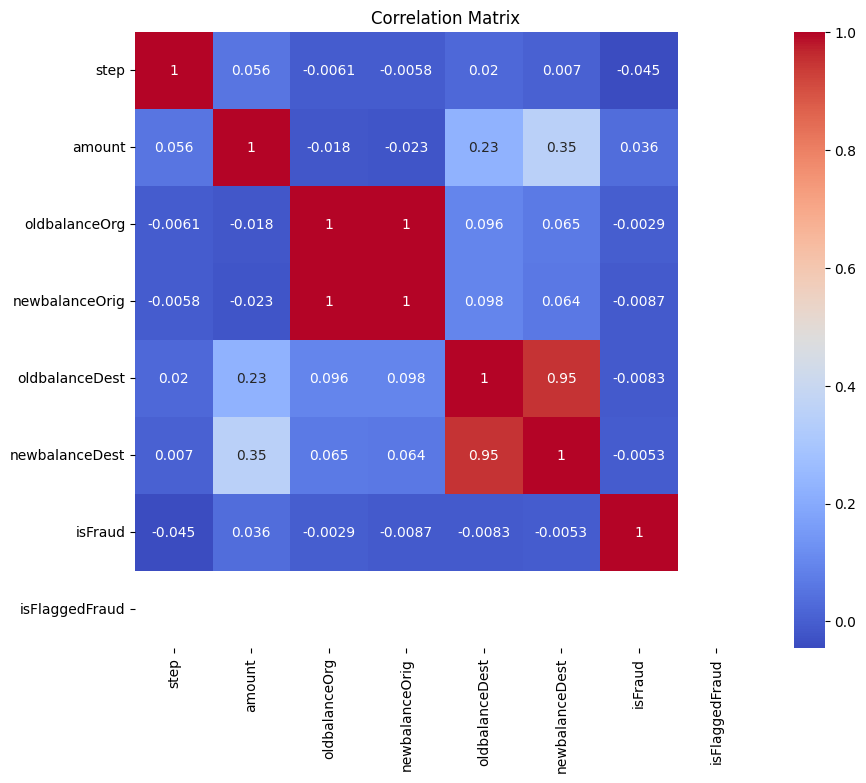

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("/content/Fraud.csv")
print("Missing values:\n", df.isnull().sum())
df.drop_duplicates(inplace=True)
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df.dropna(subset=['isFraud'], inplace=True)
print(df.describe())
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# **Fraud detection model used: Random Forest Classifier**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.dropna(subset=['isFraud'], inplace=True)
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

Confusion Matrix:
 [[33061     0]
 [   17    10]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33061
         1.0       1.00      0.37      0.54        27

    accuracy                           1.00     33088
   macro avg       1.00      0.69      0.77     33088
weighted avg       1.00      1.00      1.00     33088

ROC AUC Score: 0.9804284336361405


# **Selecting variables to be included using random forest classifier**

Top Features:
            Feature  Importance
2    oldbalanceOrg    0.158013
3   newbalanceOrig    0.145138
0             step    0.135049
4   oldbalanceDest    0.108665
10   type_TRANSFER    0.107661
5   newbalanceDest    0.105353
1           amount    0.101469
9     type_PAYMENT    0.098547
7    type_CASH_OUT    0.039485
8       type_DEBIT    0.000621


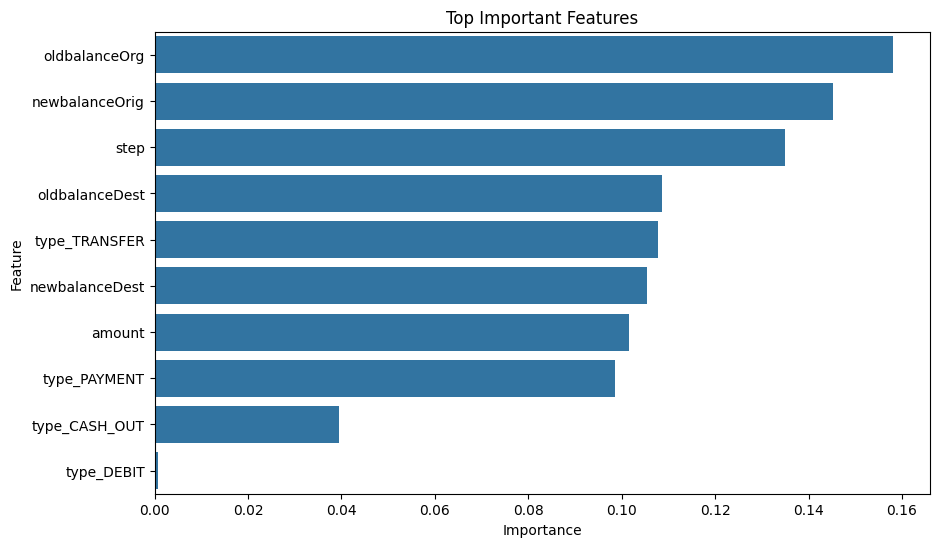

In [5]:
importances = rf.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
print("Top Features:\n", feature_df.head(10))
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(10))
plt.title("Top Important Features")
plt.show()


# **Using Cross Validation score to demonstrate model performance**

In [6]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print("Average Cross-Validated ROC AUC Score:", np.mean(cv_scores))


Average Cross-Validated ROC AUC Score: 0.9220651440215276


# **Key Factors that predict fraud customers**

In [7]:
print("Top 5 Predictive Features:")
print(feature_df.head())


Top 5 Predictive Features:
           Feature  Importance
2    oldbalanceOrg    0.158013
3   newbalanceOrig    0.145138
0             step    0.135049
4   oldbalanceDest    0.108665
10   type_TRANSFER    0.107661


# **Fraud typically happens in Payment and CASH_OUT types**

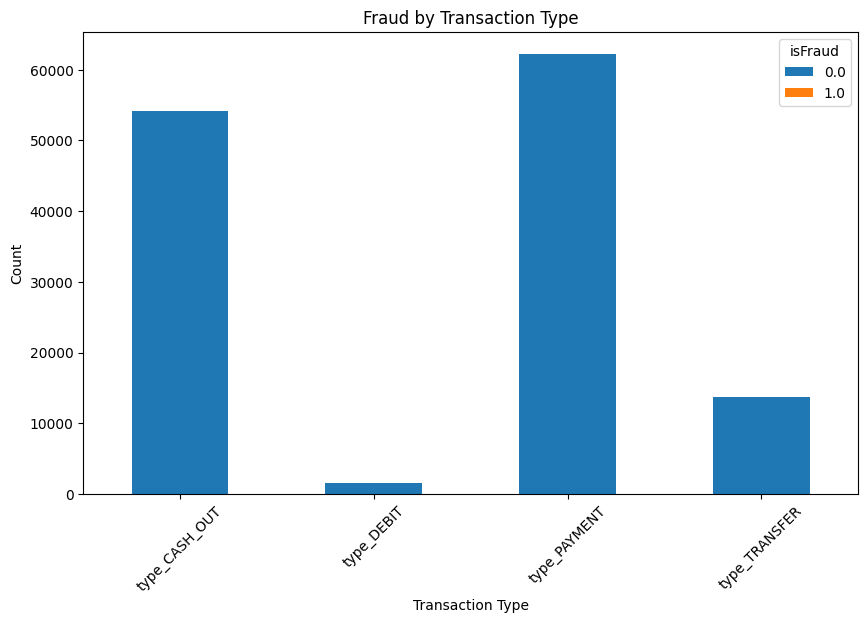

/tmp/ipython-input-16-3471105865.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['isFraud'] == 0]['amount'], df[df['isFraud'] == 1]['amount']], labels=['Not Fraud', 'Fraud'])


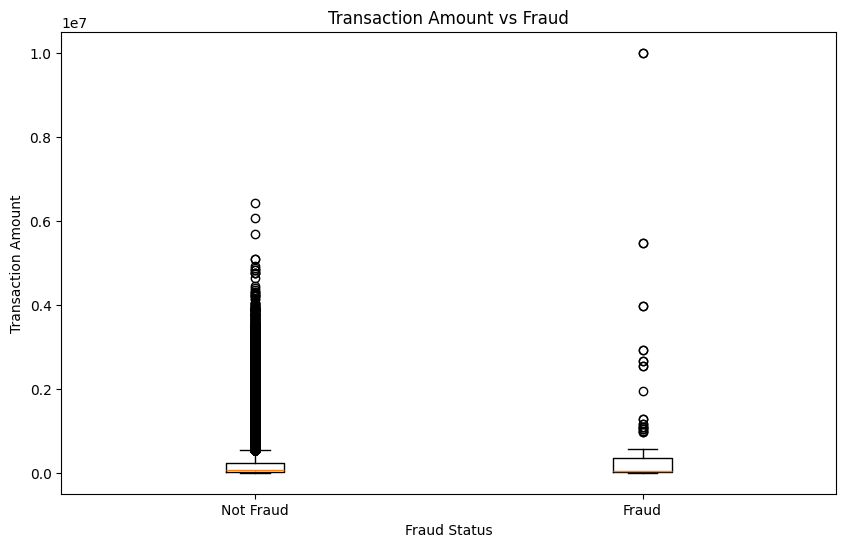

In [16]:
type_cols = [col for col in df.columns if col.startswith('type_')]
fraud_by_type = df.groupby('isFraud')[type_cols].sum().T # Transpose for plotting
fraud_by_type.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Fraud by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['isFraud'] == 0]['amount'], df[df['isFraud'] == 1]['amount']], labels=['Not Fraud', 'Fraud'])
plt.title("Transaction Amount vs Fraud")
plt.xlabel("Fraud Status")
plt.ylabel("Transaction Amount")
plt.show()

# **Prevention strategies:**
Set transaction thresholds and alerts

In [17]:
pre_update = df[df['step'] < 500]['isFraud'].mean()
post_update = df[df['step'] >= 500]['isFraud'].mean()
print("Fraud Rate Before Infrastructure Update:", pre_update)
print("Fraud Rate After Infrastructure Update:", post_update)


Fraud Rate Before Infrastructure Update: 0.000803926546500804
Fraud Rate After Infrastructure Update: nan
